# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [2]:
import sys
from pathlib import Path
import os

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Read the API keys and configuration variables from the file <root_dir>/.env
from mlfs import config
if os.path.exists(f"{root_dir}/.env"):
    settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /Users/zhangman/Documents/25_p2/scalable/lab/mlfs-book
HopsworksSettings initialized!


In [3]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from mlfs.airquality import util

In [4]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2025, 11, 17, 15, 45, 14, 439510)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [5]:
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
all_locations = json.loads(secrets.get_secret("SENSOR_LOCATION_JSON").value)
location=all_locations["sensor2"]
country=location['country']
city=location['city']
street=location['street']
# Feature groups
weather_fg = fs.get_feature_group(name='weather', version=1)
air_quality_fg = fs.get_feature_group(name='air_quality', version=1)

# Monitoring FG (same as before, now holds multiple streets)
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions_multi_sensor',
    description='Air Quality prediction monitoring with lagged feature (multi-street)',
    version=1,
    primary_key=['city', 'street', 'date', 'days_before_forecast_day'],
    event_time="date"
)

2025-11-17 15:45:15,903 INFO: Initializing external client
2025-11-17 15:45:15,903 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-17 15:45:16,595 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-17 15:45:17,596 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1296532


## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

=== Processing street: batterseaparkroad ===
2025-11-17 16:18:16,626 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/282349 elapsed<00:00 remaining<?

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.15s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.80s) 


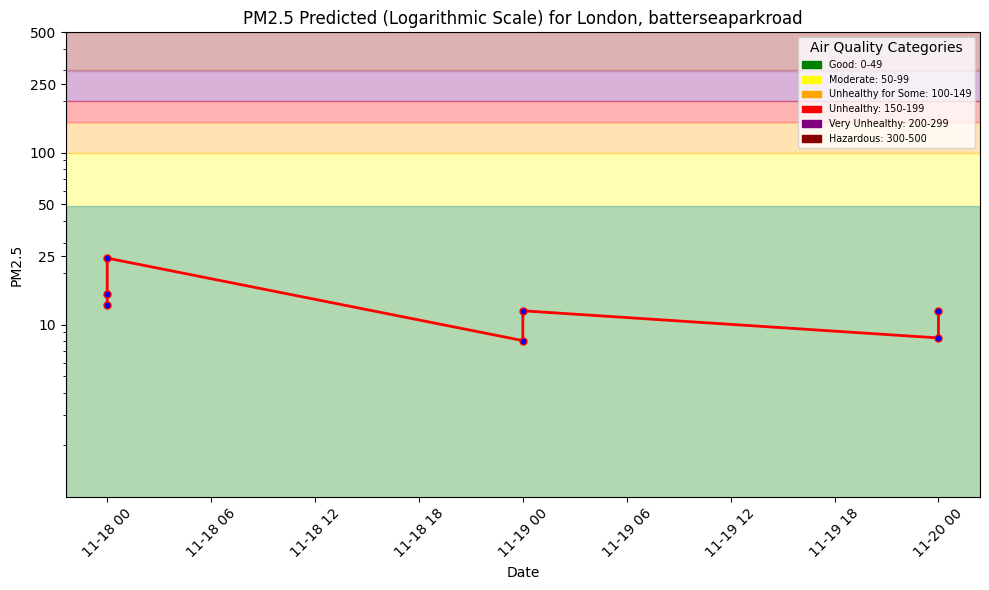

Uploading Dataframe: 100.00% |█| Rows 7/7 | Elapsed Time: 00:01 | Remaining Time


Launching job: aq_predictions_multi_sensor_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1296532/jobs/named/aq_predictions_multi_sensor_1_offline_fg_materialization/executions
2025-11-17 16:18:37,266 INFO: Waiting for execution to finish. Current state: INITIALIZING. Final status: UNDEFINED
2025-11-17 16:18:40,463 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-17 16:20:17,452 INFO: Waiting for execution to finish. Current state: SUCCEEDING. Final status: UNDEFINED
2025-11-17 16:20:20,727 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-17 16:20:20,894 INFO: Waiting for log aggregation to finish.
2025-11-17 16:20:33,126 INFO: Execution finished successfully.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.22s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Se

Uploading Dataframe: 0.00% | | Rows 0/0 | Elapsed Time: 00:00 | Remaining Time: 


Launching job: aq_predictions_multi_sensor_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1296532/jobs/named/aq_predictions_multi_sensor_1_offline_fg_materialization/executions
2025-11-17 16:20:54,240 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-17 16:21:00,623 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-17 16:22:11,039 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-17 16:22:11,214 INFO: Waiting for log aggregation to finish.
2025-11-17 16:22:19,873 INFO: Execution finished successfully.


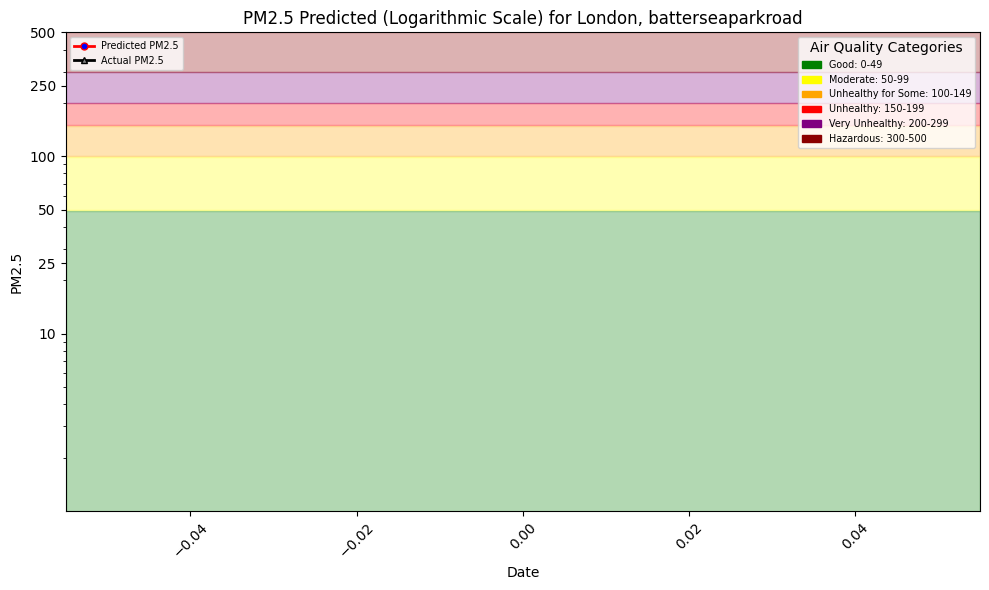

Uploading /Users/zhangman/Documents/25_p2/scalable/lab/mlfs-book/notebooks/airquality/./docs/air-quality/asset…

Uploading /Users/zhangman/Documents/25_p2/scalable/lab/mlfs-book/notebooks/airquality/./docs/air-quality/asset…

Uploaded images for batterseaparkroad to Datasets path: Resources/airquality/London_batterseaparkroad_2025-11-17

=== Processing street: london ===
2025-11-17 16:22:29,215 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/540889 elapsed<00:00 remaining<?

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.50s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.13s) 


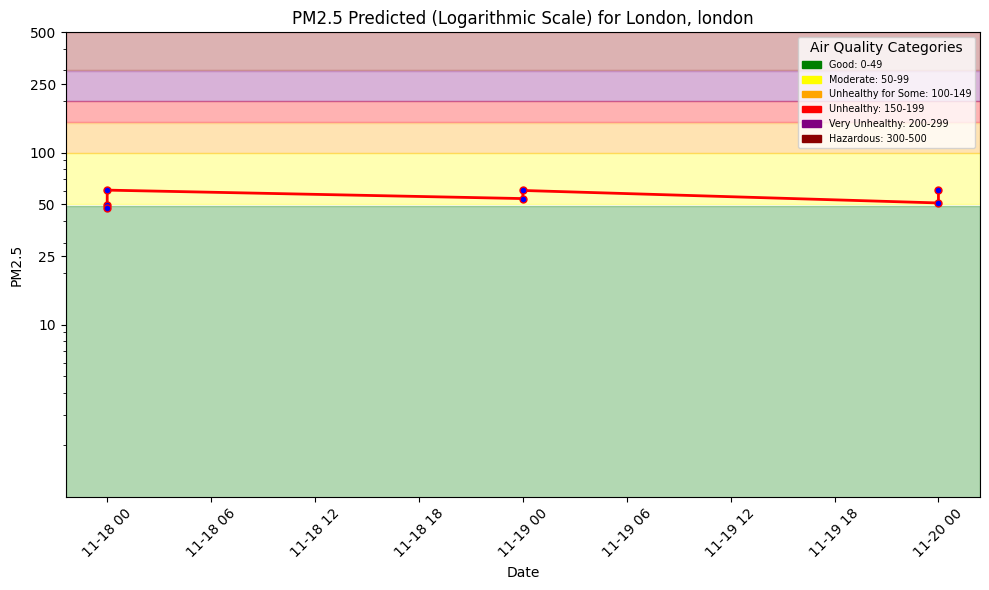

Uploading Dataframe: 100.00% |█| Rows 7/7 | Elapsed Time: 00:01 | Remaining Time


Launching job: aq_predictions_multi_sensor_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1296532/jobs/named/aq_predictions_multi_sensor_1_offline_fg_materialization/executions
2025-11-17 16:22:51,755 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-17 16:22:54,956 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-17 16:24:50,363 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-17 16:24:50,524 INFO: Waiting for log aggregation to finish.
2025-11-17 16:25:02,594 INFO: Execution finished successfully.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.11s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.06s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.85s) 
2025-11-17 16:25

Uploading Dataframe: 0.00% | | Rows 0/0 | Elapsed Time: 00:00 | Remaining Time: 


Launching job: aq_predictions_multi_sensor_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1296532/jobs/named/aq_predictions_multi_sensor_1_offline_fg_materialization/executions
2025-11-17 16:25:23,132 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-17 16:25:35,985 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-17 16:26:43,389 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-17 16:26:43,559 INFO: Waiting for log aggregation to finish.
2025-11-17 16:26:52,208 INFO: Execution finished successfully.


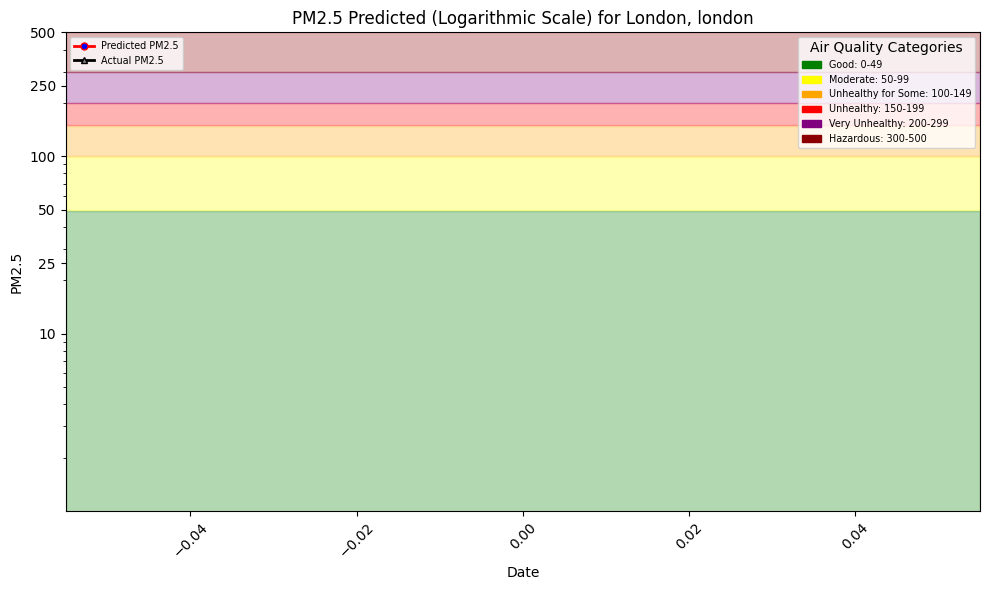

Uploading /Users/zhangman/Documents/25_p2/scalable/lab/mlfs-book/notebooks/airquality/./docs/air-quality/asset…

Uploading /Users/zhangman/Documents/25_p2/scalable/lab/mlfs-book/notebooks/airquality/./docs/air-quality/asset…

Uploaded images for london to Datasets path: Resources/airquality/London_london_2025-11-17

=== Processing street: nineelmslane ===
2025-11-17 16:27:00,662 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/285699 elapsed<00:00 remaining<?

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.05s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.74s) 


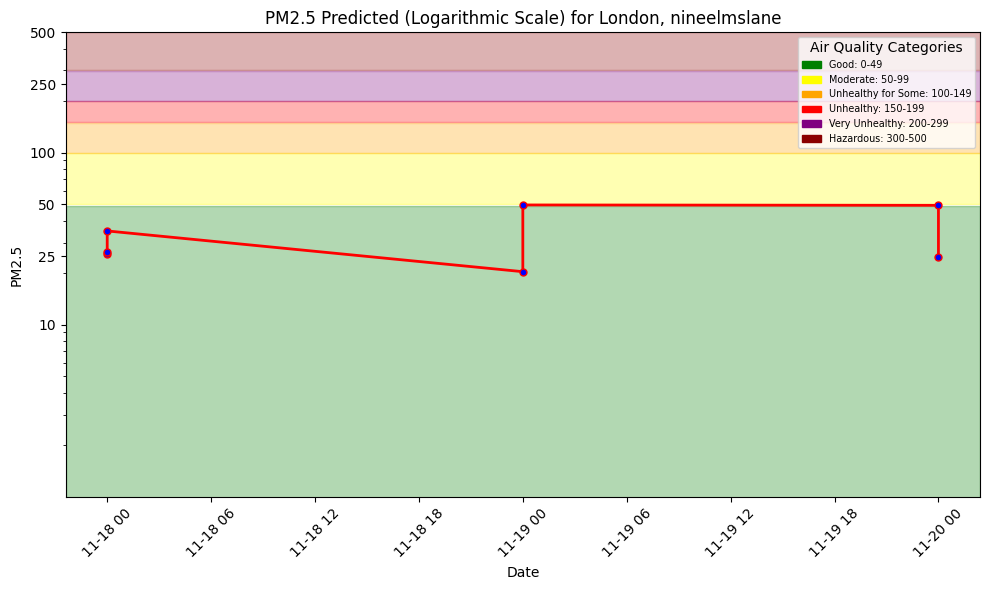

Uploading Dataframe: 100.00% |█| Rows 7/7 | Elapsed Time: 00:00 | Remaining Time


Launching job: aq_predictions_multi_sensor_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1296532/jobs/named/aq_predictions_multi_sensor_1_offline_fg_materialization/executions
2025-11-17 16:27:21,408 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-17 16:27:24,618 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-17 16:29:12,171 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-17 16:29:12,335 INFO: Waiting for log aggregation to finish.
2025-11-17 16:29:21,101 INFO: Execution finished successfully.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.28s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.81s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.99s) 
2025-11-17 16:29

Uploading Dataframe: 0.00% | | Rows 0/0 | Elapsed Time: 00:00 | Remaining Time: 


Launching job: aq_predictions_multi_sensor_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1296532/jobs/named/aq_predictions_multi_sensor_1_offline_fg_materialization/executions
2025-11-17 16:29:40,716 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-17 16:29:43,911 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-17 16:30:48,455 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-17 16:30:48,629 INFO: Waiting for log aggregation to finish.
2025-11-17 16:31:07,356 INFO: Execution finished successfully.


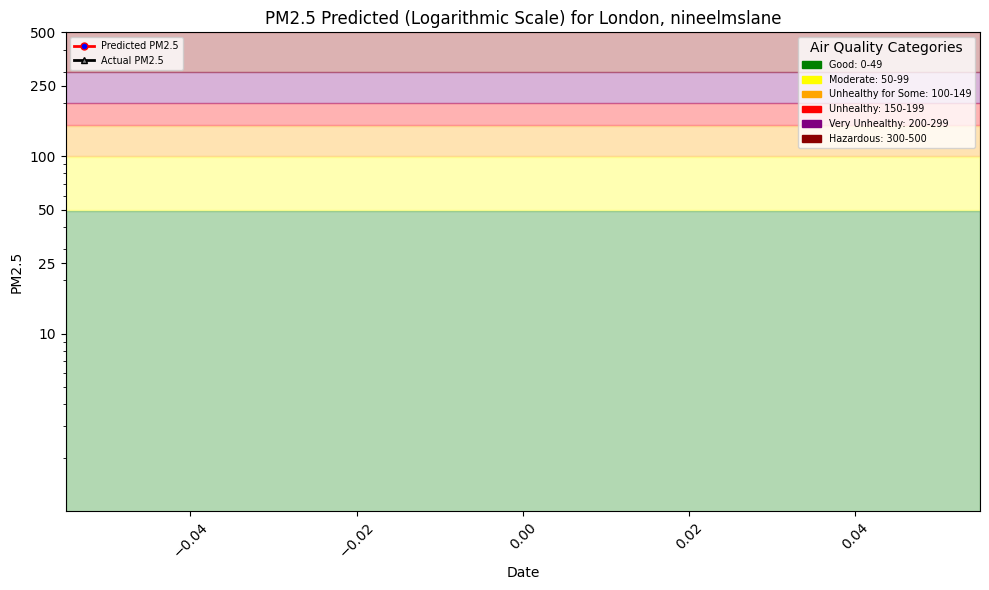

Uploading /Users/zhangman/Documents/25_p2/scalable/lab/mlfs-book/notebooks/airquality/./docs/air-quality/asset…

Uploading /Users/zhangman/Documents/25_p2/scalable/lab/mlfs-book/notebooks/airquality/./docs/air-quality/asset…

Uploaded images for nineelmslane to Datasets path: Resources/airquality/London_nineelmslane_2025-11-17



In [10]:
mr = project.get_model_registry()
dataset_api = project.get_dataset_api()
country = "United Kingdom"   # or from your secret
city = "London"

streets = [
    "batterseaparkroad",
    "london",
    "nineelmslane",
]
root_dir = "."  # or your project root

for street in streets:
    print("=== Processing street:", street, "===")

    # 1. Load the model for this street from the registry
    model_name = f"air_quality_xgboost_model_multisensor_{street}"
    retrieved_model = mr.get_model(name=model_name, version=1)
    feature_view = retrieved_model.get_feature_view()
    saved_model_dir = retrieved_model.download()

    retrieved_xgboost_model = XGBRegressor()
    retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

    # 2. Read future weather (same for all streets)
    batch_data = weather_fg.filter(weather_fg.date >= today).read()
    batch_data = batch_data.sort_values('date')

    # 3. Read recent air quality for this street to build lag
    aq_lagged_df = air_quality_fg.filter(
        (air_quality_fg.street == street)
    ).read()
    aq_lagged_df = aq_lagged_df.sort_values('date')

    # 4. Autoregressive prediction loop (same logic as your old code)
    pm25_lagged_data = []
    predictions = []
    i = 0

    for _, row in batch_data.iterrows():
        if i in [0, 1]:
            pm25_lagged = (
                aq_lagged_df.iloc[-1]["pm25"] +
                aq_lagged_df.iloc[-2]["pm25"] +
                aq_lagged_df.iloc[-3]["pm25"]
            ) / 3.0
        elif i in [2, 3]:
            pm25_lagged = (
                aq_lagged_df.iloc[-1]["pm25"] +
                aq_lagged_df.iloc[-2]["pm25"] +
                predictions[0]
            ) / 3.0
        elif i in [4, 5]:
            pm25_lagged = (
                aq_lagged_df.iloc[-1]["pm25"] +
                predictions[0] +
                predictions[1]
            ) / 3.0
        else:
            pm25_lagged = (
                predictions[i // 2 - 3] +
                predictions[i // 2 - 2] +
                predictions[i // 2 - 1]
            ) / 3.0

        features = pd.DataFrame([{
            'pm25_lagged': pm25_lagged,
            'temperature_2m_mean': row['temperature_2m_mean'],
            'precipitation_sum': row['precipitation_sum'],
            'wind_speed_10m_max': row['wind_speed_10m_max'],
            'wind_direction_10m_dominant': row['wind_direction_10m_dominant']
        }])

        prediction = retrieved_xgboost_model.predict(features)[0]
        predictions.append(prediction)
        pm25_lagged_data.append(pm25_lagged)
        i += 1

    #  Attach predictions + meta columns
    batch_data['predicted_pm25'] = predictions
    batch_data['pm25_lagged'] = pm25_lagged_data
    batch_data['street'] = street
    batch_data['city'] = city
    batch_data['country'] = country
    batch_data['days_before_forecast_day'] = range(1, len(batch_data) + 1)
    batch_data = batch_data.sort_values(by=['date'])

    # Plot 
    images_dir = f"{root_dir}/docs/air-quality/assets/img"
    if not os.path.exists(images_dir):
        os.makedirs(images_dir, exist_ok=True)

    pred_file_path = f"{images_dir}/pm25_forecast_multisensor_{street}.png"
    plt = util.plot_air_quality_forecast(city, street, batch_data, pred_file_path)
    plt.show()

    # 7. Insert into monitoring feature group
    monitor_fg.insert(batch_data, wait=True)

    # 8. Build hindcast (only 1-day-ahead forecasts) for this street
    monitoring_df = monitor_fg.filter(
        (monitor_fg.days_before_forecast_day == 1) &
        (monitor_fg.street == street)
    ).read()

    air_quality_df = air_quality_fg.filter(air_quality_fg.street == street).read()

    outcome_df = air_quality_df[['date', 'pm25']]
    preds_df = monitoring_df[['date', 'predicted_pm25']]

    hindcast_df = pd.merge(preds_df, outcome_df, on="date")
    hindcast_df = hindcast_df.sort_values(by=['date'])

    # If there are no outcomes yet, backfill for this street
    if len(hindcast_df) == 0:
        hindcast_df = util.backfill_predictions_for_monitoring_lagged(
            weather_fg,
            air_quality_df,
            monitor_fg,
            retrieved_xgboost_model
        )

    # 9. Plot hindcast for this street
    hindcast_file_path = f"{images_dir}/pm25_hindcast_1day_{street}.png"
    plt = util.plot_air_quality_forecast(city, street, hindcast_df, hindcast_file_path, hindcast=True)
    plt.show()

    # 10. Upload both images to Hopsworks Datasets
    str_today = today.strftime("%Y-%m-%d")
    dir_name = f"Resources/airquality/{city}_{street}_{str_today}"

    if not dataset_api.exists("Resources/airquality"):
        dataset_api.mkdir("Resources/airquality")

    dataset_api.upload(pred_file_path, dir_name, overwrite=True)
    dataset_api.upload(hindcast_file_path, dir_name, overwrite=True)

    print(f"Uploaded images for {street} to Datasets path: {dir_name}")
    print()

### <span style="color:#ff5f27;">🤖 Making the predictions</span>

### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

---